In [1]:
import pandas as pd
import numpy as np

dataset=pd.read_csv('data2012-2023.csv')
print(dataset.head())
dataset=dataset.values

        Date    Price     Open     High      Low  index Change %
0  1/13/2012  1639.35  1650.66  1650.75  1626.06   3103   -0.65%
1  1/16/2012  1643.40  1639.68  1647.35  1631.44   3102    0.25%
2  1/17/2012  1651.74  1643.84  1667.87  1641.45   3101    0.51%
3  1/18/2012  1661.25  1652.20  1662.50  1642.74   3100    0.58%
4  1/19/2012  1657.60  1659.70  1670.15  1648.94   3099   -0.22%


In [3]:
high_value=dataset[:,3]
print(high_value[:5])

high_value=high_value.reshape(-1,1) #convering into a column vector
print(high_value[:5])

print(high_value.shape)

[1650.75 1647.35 1667.87 1662.5 1670.15]
[[1650.75]
 [1647.35]
 [1667.87]
 [1662.5]
 [1670.15]]
(3088, 1)


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler1=MinMaxScaler(feature_range=(0,1))
scaled_high_value=scaler1.fit_transform(high_value)

print(high_value[:5])
print(scaled_high_value[:5])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[[1650.75]
 [1647.35]
 [1667.87]
 [1662.5]
 [1670.15]]
[[0.57817543]
 [0.57483984]
 [0.59497111]
 [0.58970284]
 [0.59720792]]


In [8]:
data=[]
target=[]

for i in range(50,high_value.shape[0]):
    data.append(scaled_high_value[i-50:i])
    target.append(scaled_high_value[i])



In [9]:
import numpy as np

data_np=np.array(data)
target_np=np.array(target)

print(data_np.shape)
print(target_np.shape)

(3038, 50, 1)
(3038, 1)


In [10]:
np.save('data',data)
np.save('target',target)

In [11]:
import joblib
joblib.dump(scaler1, 'stock-scaler.sav') 

['stock-scaler.sav']

In [12]:
import numpy as np

data=np.load('data.npy')
target=np.load('target.npy')

In [13]:
train_data=data[:2700]
train_target=target[:2700]

test_data=data[2700:]
test_target=target[2700:]

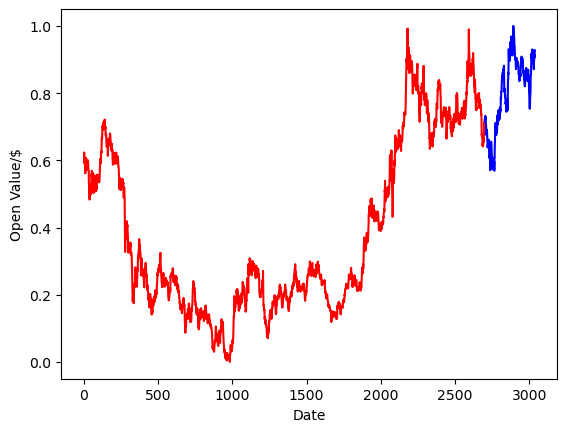

In [14]:
from matplotlib import pyplot as plt

test_x_range=np.arange(2700,3038,1)
#test_x_range is an array of values between 1000-1208

plt.plot(train_target,'r',label='train')
plt.plot(test_x_range,test_target,'b',label='test')
plt.xlabel('Date')
plt.ylabel('Open Value/$')
plt.show()

In [24]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
import numpy as np

from keras.optimizers import Adam,Adagrad,Adadelta

def build_model(parameters):
    
    model = Sequential()
    
    for i in range(parameters.Int('num_layers', 2, 20)):

        if(i==0):
            model.add(LSTM(units=parameters.Int('#neurons layer' + str(i),min_value=32,max_value=512,step=32),
                            return_sequences=True,input_shape=(data.shape[1:])))
            
            model.add(Dropout(parameters.Choice('drop_prob 1',[0.2,0.3,0.4,0.5])))
        
        else:
            model.add(LSTM(units=parameters.Int('#neurons layer' + str(i),min_value=32,max_value=512,step=32),
                                 return_sequences=True  ))
            
            model.add(Dropout(parameters.Choice('drop_prob 2',[0.2,0.3,0.4,0.5])))
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer=parameters.Choice('optmz', ['adam', 'adaDelta', 'adaGrad']),loss=parameters.Choice('loss f', ['mse', 'mae']))
    #model.compile(optimizer=Adam(parameters.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),loss='mse')
    
    return model

In [25]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(build_model,objective='val_loss',max_trials=5,executions_per_trial=3,directory='project',
                     project_name='XAUUSD-Daily-High')

In [26]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
#neurons layer0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
drop_prob 1 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4, 0.5], 'ordered': True}
#neurons layer1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
drop_prob 2 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4, 0.5], 'ordered': True}
optmz (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'adaDelta', 'adaGrad'], 'ordered': False}
loss f (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae'], 'ordered': False}


In [27]:
tuner.search(train_data,train_target,epochs=10,validation_data=(test_data, test_target))

Trial 5 Complete [00h 59m 34s]
val_loss: 0.10154302418231964

Best val_loss So Far: 0.10154302418231964
Total elapsed time: 02h 41m 37s


In [28]:
tuner.results_summary()

Results summary
Results in project\XAUUSD-Daily-High
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 4 summary
Hyperparameters:
num_layers: 14
#neurons layer0: 320
drop_prob 1: 0.3
#neurons layer1: 192
drop_prob 2: 0.5
optmz: adam
loss f: mae
#neurons layer2: 480
#neurons layer3: 128
#neurons layer4: 64
#neurons layer5: 192
#neurons layer6: 448
#neurons layer7: 288
#neurons layer8: 352
#neurons layer9: 352
#neurons layer10: 64
#neurons layer11: 128
#neurons layer12: 64
#neurons layer13: 96
#neurons layer14: 192
#neurons layer15: 288
#neurons layer16: 384
Score: 0.10154302418231964

Trial 0 summary
Hyperparameters:
num_layers: 17
#neurons layer0: 32
drop_prob 1: 0.4
#neurons layer1: 448
drop_prob 2: 0.3
optmz: adam
loss f: mae
#neurons layer2: 32
#neurons layer3: 32
#neurons layer4: 32
#neurons layer5: 32
#neurons layer6: 32
#neurons layer7: 32
#neurons layer8: 32
#neurons layer9: 32
#neurons layer10: 32
#neurons layer11: 32
#neurons layer12: 32
#neurons layer1

In [29]:
best_models = tuner.get_best_models()
print(best_models[0].summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 320)           412160    
                                                                 
 dropout (Dropout)           (None, 50, 320)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 192)           393984    
                                                                 
 dropout_1 (Dropout)         (None, 50, 192)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 480)           1292160   
                                                                 
 dropout_2 (Dropout)         (None, 50, 480)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50, 128)           3